#CTGAN with RF as classifier with different data sizes

In [ ]:
# 1) Install CTGAN (if you haven’t already):
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:

import numpy as np
import pandas as pd
from ctgan import CTGAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    f1_score # Added f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


df = pd.read_csv("creditcard.csv")
X = df.drop("Class", axis=1)
y = df["Class"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

In [ ]:
def experiment_1_scaling_ctgan(X_train_scaled, y_train, X_test_scaled, y_test, scaler,

    results = []
    sizes = [0.01, 0.05, 0.1, 0.5, 1.0]

    fraud_data = X_train_scaled[y_train == 1].reset_index(drop=True)
    nonfraud_data = X_train_scaled[y_train == 0].reset_index(drop=True)

    for frac in tqdm(sizes, desc="CTGAN Experiment Loop"):

        sample_size = int(len(fraud_data) * frac)
        fraud_subset = fraud_data.iloc[:sample_size, :].copy()


        ctgan = CTGAN(
            embedding_dim=128,
            generator_dim=(256, 256),
            discriminator_dim=(256, 256),
            generator_lr=2e-4,
            generator_decay=1e-6,
            discriminator_lr=2e-4,
            discriminator_decay=1e-6,
            batch_size=500,
            epochs=epochs,
            pac=10,
            verbose=False
        )
        ctgan.fit(fraud_subset)

        # Generate synthetic frauds
        syn_fraud = ctgan.sample(n_synth)


        X_aug = pd.concat([X_train_scaled, syn_fraud], ignore_index=True)
        y_aug = np.concatenate([y_train, np.ones(n_synth, dtype=int)])


        clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42, n_jobs=-1)
        clf.fit(X_aug, y_aug)

        # Evaluate
        y_pred = clf.predict(X_test_scaled)
        y_prob = clf.predict_proba(X_test_scaled)[:, 1]

        roc  = roc_auc_score(y_test, y_prob)
        pr   = average_precision_score(y_test, y_prob)
        f1   = f1_score(y_test, y_pred)

        results.append((int(frac * 100), roc, pr, f1))

        print(f"{int(frac*100)}% fraud used → ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | F1: {f1:.4f}")

    return results


In [ ]:
def plot_experiment_1(results):
    import matplotlib.pyplot as plt
    x = [r[0] for r in results]
    roc = [r[1] for r in results]
    pr = [r[2] for r in results]
    f1 = [r[3] for r in results]

    plt.figure(figsize=(10, 6))
    plt.plot(x, roc, label="ROC-AUC", marker='o')
    plt.plot(x, pr, label="PR-AUC", marker='s')
    plt.plot(x, f1, label="F1-score", marker='^')
    plt.xlabel("Fraud Training Set Size (%)")
    plt.ylabel("Score")
    plt.title("Experiment 1: CTGAN Performance vs Training Size")
    plt.grid(True)
    plt.legend()
    plt.show()


CTGAN Experiment Loop:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
CTGAN Experiment Loop:  20%|██        | 1/5 [04:05<16:20, 245.04s/it]

1% fraud used → ROC-AUC: 0.9554 | PR-AUC: 0.8657 | F1: 0.8466


CTGAN Experiment Loop:  40%|████      | 2/5 [08:52<13:29, 269.84s/it]

5% fraud used → ROC-AUC: 0.9644 | PR-AUC: 0.8603 | F1: 0.8235


CTGAN Experiment Loop:  60%|██████    | 3/5 [13:13<08:51, 265.98s/it]

10% fraud used → ROC-AUC: 0.9643 | PR-AUC: 0.8682 | F1: 0.8660


CTGAN Experiment Loop:  80%|████████  | 4/5 [17:55<04:32, 272.17s/it]

50% fraud used → ROC-AUC: 0.9645 | PR-AUC: 0.8555 | F1: 0.8141


CTGAN Experiment Loop: 100%|██████████| 5/5 [22:38<00:00, 271.74s/it]

100% fraud used → ROC-AUC: 0.9599 | PR-AUC: 0.8659 | F1: 0.8426


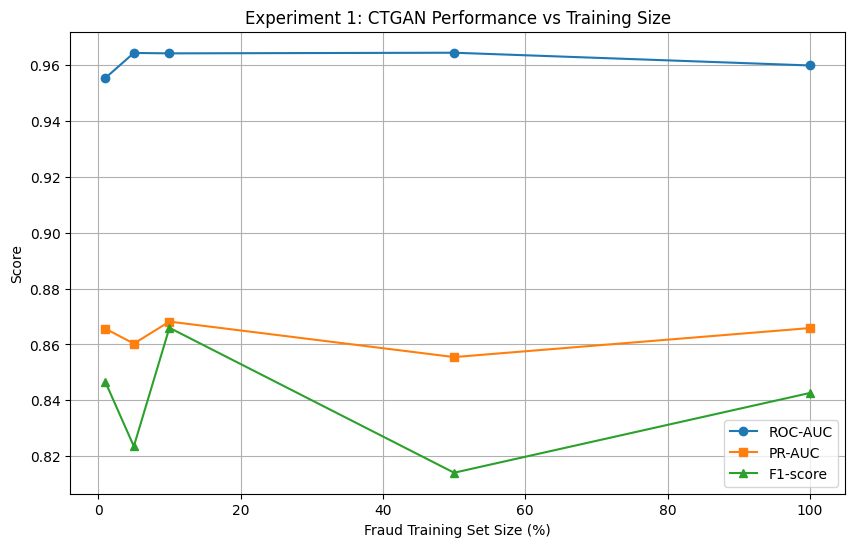

In [ ]:
results_ctgan = experiment_1_scaling_ctgan(X_train_scaled, y_train, X_test_scaled, y_test, scaler)
plot_experiment_1(results_ctgan)


Highly stable across training sizes: CTGAN achieves strong ROC-AUC and PR-AUC even with limited fraud samples, proving robustness to scarce training data.

Best at overall separation (ROC-AUC ~0.96–0.97): Outperforms standard GAN and WGAN variants in terms of stability and reliability.

F1-score is sensitive: The variability suggests CTGAN sometimes struggles with balancing fraud recall and precision at different training sizes, but it still maintains solid performance.

Practical takeaway: CTGAN is a reliable choice for fraud data augmentation, especially when fraud samples are scarce, as it consistently provides strong results across metrics.

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355), [Predicting credit card fraud using conditional generative adversarial network](https://norma.ncirl.ie/6114/), https://www.kaggle.com/datasets/gauravduttakiit/credit-card-fraud-detection-gan


Note- ChatGPT used for understanding results.